In [1]:
conda install -c conda-forge scikit-surprise

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.dataset import DatasetAutoFolds
from surprise import Reader

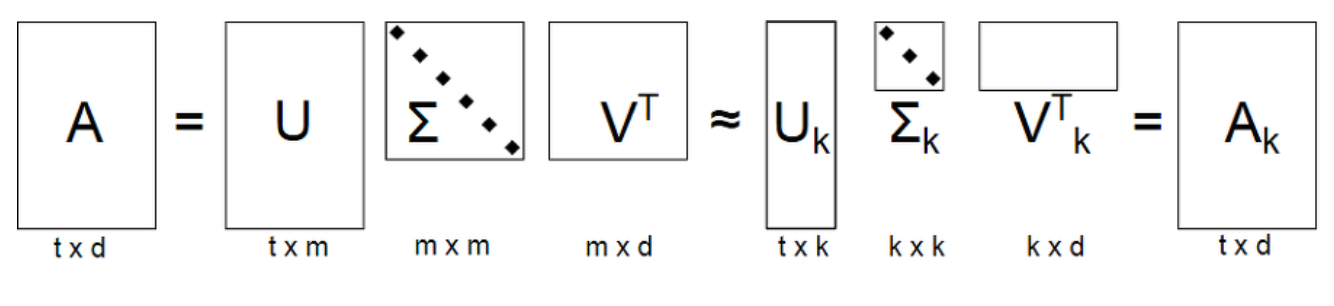

In [3]:
ratings = pd.read_csv('C://Users//dnjsw//Desktop//프로젝트//전처리//Ratings4.csv',encoding='utf-8')
books = pd.read_csv('C://Users//dnjsw//Desktop//프로젝트//전처리//Books4.csv',encoding='utf-8')
users = pd.read_csv('C://Users//dnjsw//Desktop//프로젝트//전처리//Users4.csv',encoding='utf-8')

In [4]:
bookrating = pd.merge(ratings, books, on='ISBN')
bookrating.rename(columns={'ISBN':'item'}, inplace = True)
books.rename(columns={'Book-Title':'title', 'ISBN':'item'}, inplace = True)

In [5]:
bookrating.drop(['Unnamed: 0_x'], axis=1, inplace=True)

In [6]:
bookrating.drop(['Unnamed: 0_y'], axis=1, inplace=True)

In [7]:
#bookrating.to_csv('BookRatings.csv', index=False, header = False)

In [8]:
col = 'user item rating'
reader = Reader(line_format=col, sep='\t', rating_scale=(1, 10))
data=Dataset.load_from_file('C://Users//dnjsw//Desktop//프로젝트//New//BookRatings.txt', reader=reader)

In [9]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=0)

algo = SVD(random_state=0) #기본값은 100, 20

In [10]:
# 학습 데이터세트로 학습하고, 테스트 데이터 세트로 평점 예측 후, RMSE 평가

algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.6967
1.6967434544799913


In [11]:
predictions[0]

Prediction(uid='195906', iid='3518398709', r_ui=10.0, est=7.858250228764362, details={'was_impossible': False})

## 개인화 도서 추천 시스템 구축

In [13]:
col = 'user item rating'
reader = Reader(line_format=col, sep='\t', rating_scale=(1,10))

# DatasetAutoFolds 클래스를 생성 -> train,test 안나누고 전체데이터 학습
data_folds = DatasetAutoFolds(ratings_file = 'C://Users//dnjsw//Desktop//프로젝트//New//BookRatings.txt', reader=reader)

# 전체 데이터를 학습 데이터로 생성
trainset = data_folds.build_full_trainset()

In [15]:
algo = SVD()
algo.fit(trainset)

In [16]:
# SVD를 이용해 학습을 수행, 특정 사용자를 임의로 userId=9로 지정하여,
# 도서를 추천하기 위해 아직 보지 않은 도서 목록 확인해보기

ISBNs = bookrating[bookrating['User-ID']==9]['item']

if ISBNs[ISBNs=='034545104X'].count() == 0 :
    print('사용자 아이디 9는 ISBN 034545104X의 평점없음')

books[books['item']=='034545104X']

사용자 아이디 9는 ISBN 034545104X의 평점없음


,Unnamed: 0,item,title,Book-Author
497,2966,034545104X,Flesh Tones: A Novel,M. J. Rose


In [17]:
# 유저아이디 uid, 아이템아이디 iid

uid = str(9)
iid = str('034545104X')

pred = algo.predict(uid, iid, verbose=True)
pred

user: 9          item: 034545104X r_ui = None   est = 6.64   {'was_impossible': False}


Prediction(uid='9', iid='034545104X', r_ui=None, est=6.6394376963577955, details={'was_impossible': False})

## 높은 예측 평점을 가진 순으로 도서 추천해보기

- 사용자가 평점을 안매긴 전체 도서를 추출 예측 평점 순으로 도서를 추천해보기
- 특정 유저의 추천 도서 추출

In [18]:
def get_unread_surprise(userId):
    # userId에 해당하는 평점 매긴 모든 도서를 리스트로 생성
    read_books = bookrating[bookrating['User-ID']==userId]['item'].tolist()
    
    # 모든 도서의 ISBN을 리스트로 생성
    total_books = books['item'].tolist()
    
    # 모든 도서의 ISBN 중 이미 평점 매긴 도서를 제외한 후 리스트 생성
    unread_books = [book for book in total_books if book not in read_books]
    print('평점 매긴 도서 수 :', len(read_books))
    print('추천 대상 도서 수 :', len(unread_books))
    print('전체 도서 수 :', len(total_books))
    
    return unread_books

In [19]:
unread_books = get_unread_surprise(276847)

평점 매긴 도서 수 : 33
추천 대상 도서 수 : 33411
전체 도서 수 : 33444


In [20]:
# 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
predictions = [algo.predict(str(276847), str(item)) for item in unread_books]

print('prediction type : ', type(predictions), 'size : ', len(predictions))
print('152805 유저의 prediction 결과 5개')
for i in range(5):
    print(predictions[i])

prediction type :  <class 'list'> size :  33411
152805 유저의 prediction 결과 5개
user: 276847     item: 1881320189 r_ui = None   est = 8.72   {'was_impossible': False}
user: 276847     item: 1841721522 r_ui = None   est = 9.27   {'was_impossible': False}
user: 276847     item: 067176537X r_ui = None   est = 8.65   {'was_impossible': False}
user: 276847     item: 042518630X r_ui = None   est = 8.05   {'was_impossible': False}
user: 276847     item: 2070423204 r_ui = None   est = 8.50   {'was_impossible': False}


In [21]:
def recomm_book_by_surprise(algo, userId, unread_books, top_n=10):
    
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(item)) for item in unread_books]
    
    # est 값으로 정렬 -> sortkey_eat 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행
    def sortkey_est(pred):
        return pred.est
    
# sortkey_est() 반환값의 내림차순으로 정렬, top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions = predictions[:top_n]
    for i in range(3):
        print(top_predictions[i])

  # top_n으로 추출된 도서의 정보 추출, 도서정보, 예상 평점, 제목 추출
    top_book_ids = [pred.iid for pred in top_predictions] # 도서정보
    top_book_rating = [pred.est for pred in top_predictions] # 예상 평점
    top_book_titles = bookrating[bookrating.item.isin(top_book_ids)]['Book-Title']
    #top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']

    top_book_preds = [ (id, rating) for id, rating in 
                      zip(top_book_ids, top_book_rating)]
    return top_book_preds

In [22]:
unread_books = get_unread_surprise(276847)
top_book_preds = recomm_book_by_surprise(algo,276847, unread_books, top_n=10)

print('  ')
print('  ')
print('*********************************')
print('*** 추천 도서 리스트 Top 10 ***')
print('  ')
for top_book in top_book_preds :
    print(top_book[0], ":", round(top_book[1],2))

평점 매긴 도서 수 : 33
추천 대상 도서 수 : 33411
전체 도서 수 : 33444
user: 276847     item: 1880418568 r_ui = None   est = 9.79   {'was_impossible': False}
user: 276847     item: 043935806X r_ui = None   est = 9.77   {'was_impossible': False}
user: 276847     item: 055321313X r_ui = None   est = 9.76   {'was_impossible': False}
  
  
*********************************
*** 추천 도서 리스트 Top 10 ***
  
1880418568 : 9.79
043935806X : 9.77
055321313X : 9.76
067168390X : 9.76
039480001X : 9.7
038548951X : 9.55
3499224623 : 9.54
043936213X : 9.49
089480829X : 9.46
8478886451 : 9.44


In [23]:
for top_book in top_book_preds:
    print(bookrating[bookrating.item == top_book[0]]['Book-Title'].unique(),":",round(top_book[1],2))

['Wolves of the Calla (The Dark Tower, Book 5)'] : 9.79
['Harry Potter and the Order of the Phoenix (Book 5)'] : 9.77
['Anne of Green Gables (Anne of Green Gables Novels (Paperback))'] : 9.76
['Lonesome Dove'] : 9.76
['The Cat in the Hat'] : 9.7
['Sister of My Heart'] : 9.55
['Maus 2. Und hier begann mein Ungl횄?횂쩌ck. Die Geschichte eines 횄?횂?berlebenden.'] : 9.54
["Harry Potter and the Sorcerer's Stone (Book 1)"] : 9.49
["What to Expect When You're Expecting (Revised Edition)"] : 9.46
['Harry Potter y el c횄징liz de fuego'] : 9.44


In [24]:
final = [bookrating[bookrating.item == top_book[0]]['Book-Title'].unique() for top_book in top_book_preds]
rating = [round(top_book[1],2) for top_book in top_book_preds]

result={
    'Title':final,
    'Rating_pred':rating
}

result_df = pd.DataFrame(result)

In [25]:
result_df

,Title,Rating_pred
0,"[Wolves of the Calla (The Dark Tower, Book 5)]",9.79
1,[Harry Potter and the Order of the Phoenix (Bo...,9.77
2,[Anne of Green Gables (Anne of Green Gables No...,9.76
3,[Lonesome Dove],9.76
4,[The Cat in the Hat],9.70
5,[Sister of My Heart],9.55
6,[Maus 2. Und hier begann mein Ungl횄?횂쩌ck. Die ...,9.54
7,[Harry Potter and the Sorcerer's Stone (Book 1)],9.49
8,[What to Expect When You're Expecting (Revised...,9.46
9,[Harry Potter y el c횄징liz de fuego],9.44
